# Reinforcement Learning model


In [ ]:
pip install ultralytics #stable-baselines3 gymnasium torch torchvision

In [ ]:
from ultralytics import YOLO
import numpy as np

# YOLOv8 modelini yükle
model = YOLO("yolov8n.pt")

# Görseldeki kusurları tespit eden fonksiyon
def detect_defects(image_path):
    results = model(image_path)
    detections = []

    # Modelin tespit ettiği nesnelerden bounding box bilgilerini al
    for r in results:
        for box in r.boxes.data.tolist():
            x1, y1, x2, y2, conf = box[:5]  # (x1, y1, x2, y2, confidence)
            detections.append((x1, y1, x2, y2, conf))

    return detections


In [ ]:
import gym
import random

class DefectLabelingEnv(gym.Env):
    def __init__(self, image_path):
        super(DefectLabelingEnv, self).__init__()
        self.image_path = image_path
        self.detections = detect_defects(image_path)  # YOLOv8 ile tespit edilen bölgeler
        self.action_space = gym.spaces.Discrete(3)  # 0: Kusurlu, 1: Kusursuz, 2: Belirsiz

        # Gözlem alanı sadece 5 boyutlu: (x1, y1, x2, y2, conf)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)
        self.index = 0  # İşlenecek nesnenin sırası

    def step(self, action):
        x1, y1, x2, y2, conf = self.detections[self.index]

        # Simüle edilmiş gerçek etiket (Bunu datasetinize göre değiştirebilirsiniz)
        true_label = random.choice([0, 1])

        # Ödül fonksiyonu
        reward = 1 if action == true_label else -1

        self.index += 1
        done = self.index >= len(self.detections)

        # Yeni `state` artık sadece (5,) boyutunda
        next_state = np.array([x1, y1, x2, y2, conf], dtype=np.float32)

        return next_state, reward, done, {}

    def reset(self):
        self.index = 0
        x1, y1, x2, y2, conf = self.detections[self.index]
        return np.array([x1, y1, x2, y2, conf], dtype=np.float32)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class DRLModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(DRLModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),  # Artık input_size = 5
            nn.ReLU(),
            nn.Linear(128, output_size)
        )

    def forward(self, x):
        return self.fc(x)

# Modeli oluştur
model = DRLModel(5, 3)  # 5 giriş (bounding box bilgileri), 3 çıkış (kusurlu, kusursuz, belirsiz)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


In [ ]:
import cv2
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np

class DefectLabelingEnv:
    def __init__(self, image_folder_path):
        self.image_paths = [os.path.join(image_folder_path, f) for f in os.listdir(image_folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
        # Transform operations
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize to a more standard size
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def reset(self):
        self.current_image_idx = 0
        return self._get_state()

    def _get_state(self):
        self.current_image_path = self.image_paths[self.current_image_idx]
        img = Image.open(self.current_image_path).convert("RGB")
        img_tensor = self.transform(img)

        # Extract 5 features from the image for the state
        # This is a simple example - you might want to use a feature extractor in practice
        # For now, we'll just use basic statistics of the image as features
        features = [
            img_tensor.mean().item(),  # Mean pixel value
            img_tensor.std().item(),   # Standard deviation
            img_tensor[0].mean().item(),  # Red channel mean
            img_tensor[1].mean().item(),  # Green channel mean
            img_tensor[2].mean().item()   # Blue channel mean
        ]

        return np.array(features, dtype=np.float32)

    def step(self, action):
        # Process the action (not implemented in this example)

        # Move to the next image
        self.current_image_idx += 1
        if self.current_image_idx >= len(self.image_paths):
            self.current_image_idx = 0
            done = True
        else:
            done = False

        # Get the new state
        new_state = self._get_state()

        # Simple reward function
        reward = 1.0

        return new_state, reward, done

# Define your DQN model
class DQN(torch.nn.Module):
    def __init__(self, state_size=5, action_size=2):
        super(DQN, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(state_size, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, action_size)
        )

    def forward(self, x):
        return self.fc(x)

# Training function
def train_drl(env, model, episodes=1000):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Convert state to tensor
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # [1, 5]

            # Get action from model
            q_values = model(state_tensor)
            action = torch.argmax(q_values).item()

            # Take action in environment
            next_state, reward, done = env.step(action)
            total_reward += reward

            # Convert next_state to tensor
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

            # Calculate target Q-value
            target_q = reward + 0.99 * torch.max(model(next_state_tensor)).item() * (1 - done)

            # Update model
            target = q_values.clone()
            target[0, action] = target_q

            loss = criterion(q_values, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state

        if episode % 10 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}")

# Create environment and model
env = DefectLabelingEnv("/content/drive/MyDrive/My Project-2/train/images")
model = DQN(state_size=5, action_size=2)  # Assuming 2 possible actions

# Train the model
#train_drl(env, model)

In [ ]:
import os
import cv2
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from ultralytics import YOLO
from collections import deque
from PIL import Image

# Sabitler
MEMORY_SIZE = 5000
BATCH_SIZE = 32
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995
LEARNING_RATE = 0.001

class DQNModel(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQNModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.network(x)

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        if len(self.memory) < batch_size:
            return None
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

class RLAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.policy_net = DQNModel(state_dim, action_dim)
        self.target_net = DQNModel(state_dim, action_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)
        self.memory = ReplayMemory(MEMORY_SIZE)
        self.epsilon = EPSILON_START

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = self.policy_net(state_tensor)
                return q_values.max(1)[1].item()

    def update_epsilon(self):
        self.epsilon = max(EPSILON_END, self.epsilon * EPSILON_DECAY)

    def optimize(self):
        batch = self.memory.sample(BATCH_SIZE)
        if batch is None:
            return

        states, actions, rewards, next_states, dones = batch

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        current_q = self.policy_net(states).gather(1, actions)
        next_q = self.target_net(next_states).max(1)[0].detach()
        target_q = rewards + (1 - dones) * GAMMA * next_q

        loss = nn.MSELoss()(current_q.squeeze(), target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Hedef ağı güncelle
        self.target_net.load_state_dict(self.policy_net.state_dict())

def extract_features(results):
    # YOLO sonuçlarından özellik çıkarma
    boxes = results.boxes
    if len(boxes) == 0:
        return np.zeros(5)  # Boş özellik vektörü

    confidences = boxes.conf.cpu().numpy()
    classes = boxes.cls.cpu().numpy() if len(boxes.cls) > 0 else np.array([])

    features = [
        len(np.unique(classes)) if len(classes) > 0 else 0,  # Benzersiz sınıf sayısı
        np.max(confidences) if len(confidences) > 0 else 0,  # En yüksek güven skoru
        np.mean(confidences) if len(confidences) > 0 else 0,  # Ortalama güven skoru
        len(confidences),  # Toplam kutu sayısı
        np.std(confidences) if len(confidences) > 1 else 0  # Güven skorlarının standart sapması
    ]

    return np.array(features)

def save_yolo_labels(results, output_path, img_shape):
    # YOLO tespit sonuçlarını standart YOLO etiket formatında kaydet
    height, width = img_shape[:2]
    with open(output_path, 'w') as f:
        if hasattr(results.boxes, 'cls') and len(results.boxes.cls) > 0:
            for i, box in enumerate(results.boxes.xyxyn):
                cls = int(results.boxes.cls[i].item())
                x1, y1, x2, y2 = box[0].item(), box[1].item(), box[2].item(), box[3].item()

                # YOLO formatına dönüştür (orta nokta + genişlik-yükseklik)
                x_center = (x1 + x2) / 2
                y_center = (y1 + y2) / 2
                w = x2 - x1
                h = y2 - y1

                f.write(f"{cls} {x_center} {y_center} {w} {h}\n")

def main():
    # YOLOv8 modelini yükle
    model_path = "/content/drive/MyDrive/yolov8_model.pt"  # Sizin modelinizin yolu
    print(f"YOLOv8 modeli yükleniyor: {model_path}")
    model = YOLO(model_path)

    # Klasörleri oluştur
    image_folder = "/content/drive/MyDrive/RL deep/train/images"  # Etiketlenmemiş görüntülerin bulunduğu klasör
    if not os.path.exists(image_folder):
        print(f"'{image_folder}' klasörü bulunamadı. Lütfen görüntüleriniz için bu klasörü oluşturun.")
        return

    output_dir = "output_labels"
    os.makedirs(os.path.join(output_dir, "auto_accepted"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "manual_review"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "skipped"), exist_ok=True)

    # RL ajanını başlat
    state_dim = 5  # Özellik vektörünün boyutu
    action_dim = 3  # Eylem sayısı (kabul et, manuel inceleme, atla)
    agent = RLAgent(state_dim, action_dim)

    # Görüntü dosyalarını listele
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        print(f"'{image_folder}' klasöründe görüntü dosyası bulunamadı.")
        return

    print(f"Toplam {len(image_files)} görüntü işlenecek.")

    # Eğitim döngüsü
    epochs = 3
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        random.shuffle(image_files)

        for idx, filename in enumerate(image_files):
            img_path = os.path.join(image_folder, filename)
            image = cv2.imread(img_path)
            if image is None:
                print(f"Görüntü yüklenemedi: {img_path}")
                continue

            # YOLOv8 tespiti yap
            results = model(image)[0]

            # Özellik çıkar
            state = extract_features(results)

            # Eylemi seç
            action = agent.select_action(state)

            # Geri bildirimi simüle et (gerçek kullanımda kullanıcı tarafından sağlanmalı)
            confidences = results.boxes.conf.cpu().numpy() if hasattr(results.boxes, 'conf') else np.array([])
            if len(confidences) > 0:
                avg_conf = np.mean(confidences)
                if avg_conf > 0.7:
                    ideal_action = 0  # Kabul et
                elif avg_conf > 0.4:
                    ideal_action = 1  # Manuel inceleme
                else:
                    ideal_action = 2  # Atla
            else:
                ideal_action = 2  # Tespit yoksa atla

            # Ödül belirle
            reward = 1.0 if action == ideal_action else -0.5

            # Hafızaya ekle
            agent.memory.add(state, action, reward, state, True)

            # Optimize et
            if len(agent.memory) >= BATCH_SIZE:
                agent.optimize()

            # Epsilon'u güncelle
            agent.update_epsilon()

            # Eylemi uygula ve sonucu kaydet
            base_name = os.path.splitext(filename)[0]

            if action == 0:  # Otomatik kabul
                output_img_path = os.path.join(output_dir, "auto_accepted", filename)
                label_path = os.path.join(output_dir, "auto_accepted", f"{base_name}.txt")
                cv2.imwrite(output_img_path, image)
                save_yolo_labels(results, label_path, image.shape)
                action_text = "kabul edildi"

            elif action == 1:  # Manuel inceleme
                output_img_path = os.path.join(output_dir, "manual_review", filename)
                cv2.imwrite(output_img_path, image)
                action_text = "manuel inceleme gerekiyor"

            else:  # Atla
                output_img_path = os.path.join(output_dir, "skipped", filename)
                cv2.imwrite(output_img_path, image)
                action_text = "atlandı"

            if (idx + 1) % 10 == 0:
                print(f"İşlenen görüntü: {idx+1}/{len(image_files)} - Epsilon: {agent.epsilon:.3f}")

    print("Eğitim tamamlandı.")

    # Modeli kaydet
    torch.save({
        'policy_net': agent.policy_net.state_dict(),
        'epsilon': agent.epsilon,
    }, "rl_agent.pth")
    print("RL ajanı kaydedildi: rl_agent.pth")

    print("\nİşlem Özeti:")
    print(f"Toplam İşlenen Görüntü: {len(image_files)}")
    auto_accepted = len(os.listdir(os.path.join(output_dir, "auto_accepted")))
    manual_review = len(os.listdir(os.path.join(output_dir, "manual_review")))
    skipped = len(os.listdir(os.path.join(output_dir, "skipped")))

    print(f"Otomatik Kabul Edilen: {auto_accepted}")
    print(f"Manuel İnceleme Gerektiren: {manual_review}")
    print(f"Atlanan: {skipped}")



Streaming output truncated to the last 5000 lines.
0: 640x640 2 batiks, 390.4ms
Speed: 4.0ms preprocess, 390.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 kazintis, 309.8ms
Speed: 5.0ms preprocess, 309.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leke, 325.1ms
Speed: 7.4ms preprocess, 325.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 batiks, 272.7ms
Speed: 3.5ms preprocess, 272.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
İşlenen görüntü: 200/602 - Epsilon: 0.367

0: 640x640 2 batiks, 289.2ms
Speed: 3.8ms preprocess, 289.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 kirisiks, 279.1ms
Speed: 4.2ms preprocess, 279.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 kazintis, 270.7ms
Speed: 4.4ms preprocess, 270.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x

In [ ]:
import os
import shutil
from collections import Counter

# Klasörlerdeki dosya sayıları
auto_accepted = os.listdir("output_labels/auto_accepted")
manual_review = os.listdir("output_labels/manual_review")
skipped = os.listdir("output_labels/skipped")

print(f"Auto Accepted: {len(auto_accepted)} dosya")
print(f"Manuel İnceleme: {len(manual_review)} dosya")
print(f"Atlanan: {len(skipped)} dosya")

# Orijinal görüntü adlarını analiz et
auto_names = [os.path.splitext(f)[0] for f in auto_accepted if not f.endswith('.txt')]
manual_names = [os.path.splitext(f)[0] for f in manual_review]
skipped_names = [os.path.splitext(f)[0] for f in skipped]

# Tüm görüntü adlarını bir araya getir
all_names = auto_names + manual_names + skipped_names
duplicates = [item for item, count in Counter(all_names).items() if count > 1]

print(f"Tekrarlanan görüntü adları: {len(duplicates)}")

Auto Accepted: 892 dosya
Manuel İnceleme: 711 dosya
Atlanan: 599 dosya
Tekrarlanan görüntü adları: 458


In [ ]:
from ultralytics import YOLO
import cv2

model = YOLO("/content/drive/MyDrive/yolov8_model.pt")

# Örnek bir görüntüyü incele
sample_auto = os.path.join("output_labels/auto_accepted", auto_accepted[0])
if os.path.isfile(sample_auto) and not sample_auto.endswith('.txt'):
    img = cv2.imread(sample_auto)
    results = model(img)[0]

    print(f"Örnek otomatik kabul edilen görüntü: {sample_auto}")
    print(f"Tespit edilen nesne sayısı: {len(results.boxes)}")
    print(f"Ortalama güven skoru: {results.boxes.conf.mean().item() if len(results.boxes) > 0 else 0}")


0: 640x640 1 batik, 3 kirisiks, 258.3ms
Speed: 6.3ms preprocess, 258.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Örnek otomatik kabul edilen görüntü: output_labels/auto_accepted/Ekran-Resmi-2025-03-11-15_04_52_png.rf.9b73152b11cd5539d068a938a4e39ae5.jpg
Tespit edilen nesne sayısı: 4
Ortalama güven skoru: 0.4062201976776123


In [ ]:
import torch

# RL modelini yükle
rl_model = torch.load("rl_agent.pth")
print("RL model bilgileri:")
print(f"Epsilon değeri: {rl_model['epsilon']}")

RL model bilgileri:
Epsilon değeri: 0.01


In [ ]:
# Otomatik kabul edilen etiketleri kontrol et
txt_files = [f for f in auto_accepted if f.endswith('.txt')]
if txt_files:
    sample_label = os.path.join("output_labels/auto_accepted", txt_files[0])
    print(f"Örnek etiket içeriği: {sample_label}")
    with open(sample_label, 'r') as f:
        content = f.read()
        print(content)

Örnek etiket içeriği: output_labels/auto_accepted/89_png.rf.79206bf701dc85e8f9606aa9bac94b84.txt
4 0.5233635753393173 0.4803956151008606 0.42224958539009094 0.9607912302017212



Otomatik Kabul Edilen Örnekler:


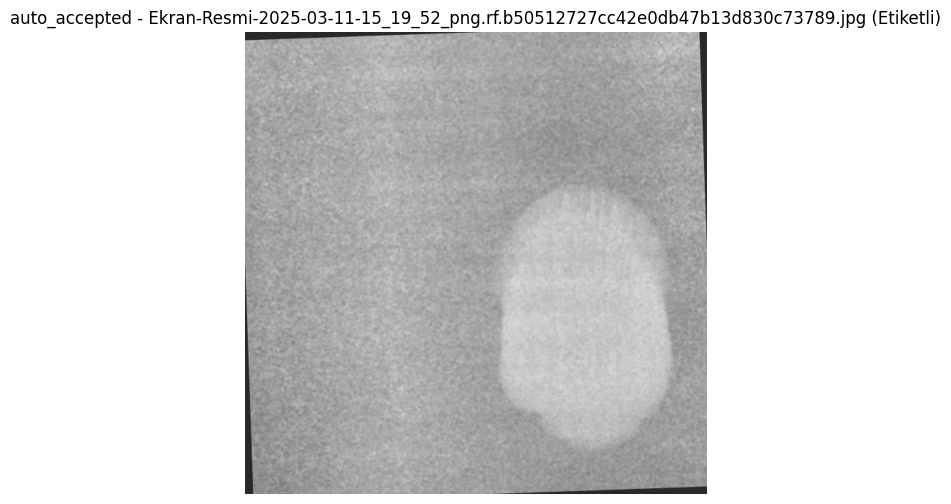

Etiket içeriği:
4 0.739487498998642 0.6193694174289703 0.37843233346939087 0.5998625159263611



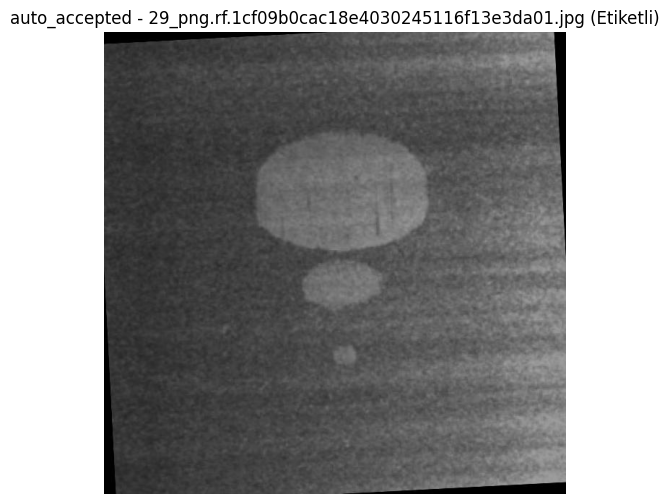

Etiket içeriği:
4 0.5145995169878006 0.34803323447704315 0.4084812104701996 0.28271952271461487
4 0.5155841708183289 0.5469322800636292 0.17459523677825928 0.12111151218414307
4 0.5233706533908844 0.7021906673908234 0.056777894496917725 0.05242365598678589



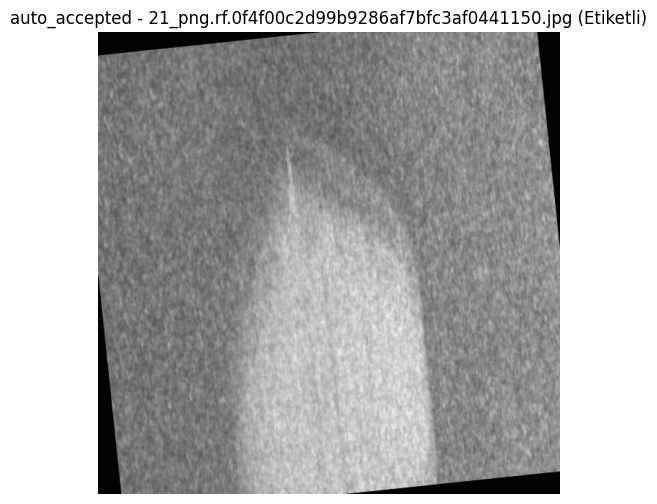

Etiket içeriği:
4 0.504201352596283 0.5782009959220886 0.46930110454559326 0.8248637914657593



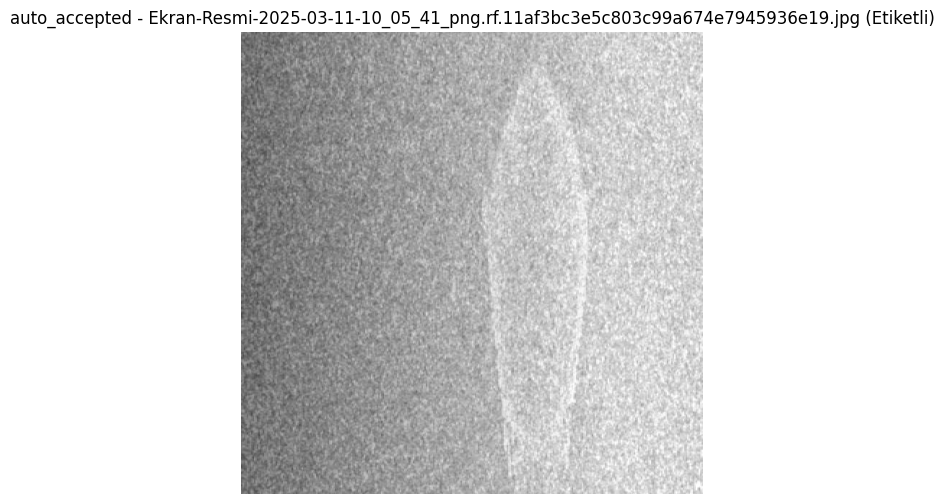

Etiket içeriği:
4 0.6454162299633026 0.5143880844116211 0.28005820512771606 0.9712238311767578



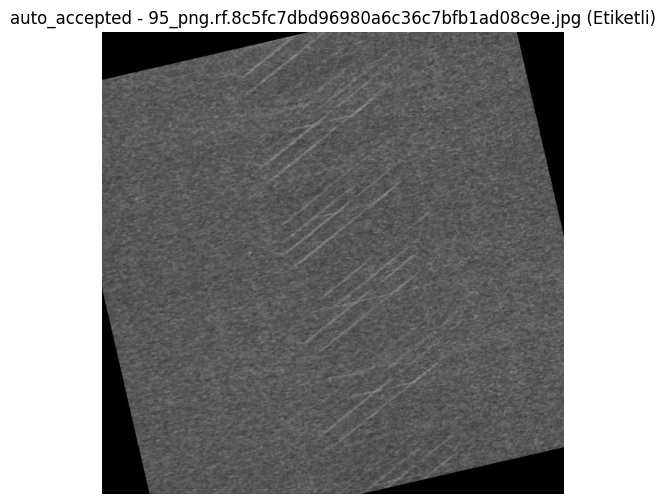

Etiket içeriği:
2 0.5502354949712753 0.5702154636383057 0.2768996059894562 0.27516603469848633
2 0.6011443585157394 0.7855037152767181 0.27072516083717346 0.26837342977523804
2 0.5109585821628571 0.38701674342155457 0.3030700087547302 0.2657627463340759
2 0.47137099504470825 0.18189852219074965 0.29320716857910156 0.30806698836386204
2 0.39033985137939453 0.0676981657743454 0.19088953733444214 0.1353963315486908
2 0.6283972710371017 0.9114280641078949 0.32178953289985657 0.1763736605644226


Manuel İnceleme Gerektiren Örnekler:


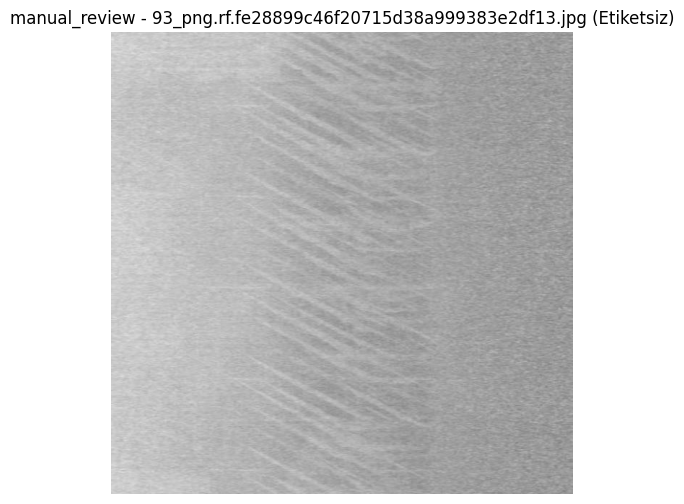

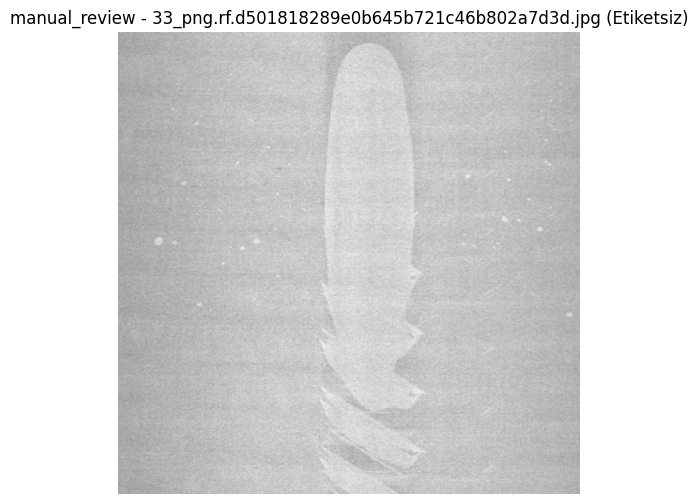

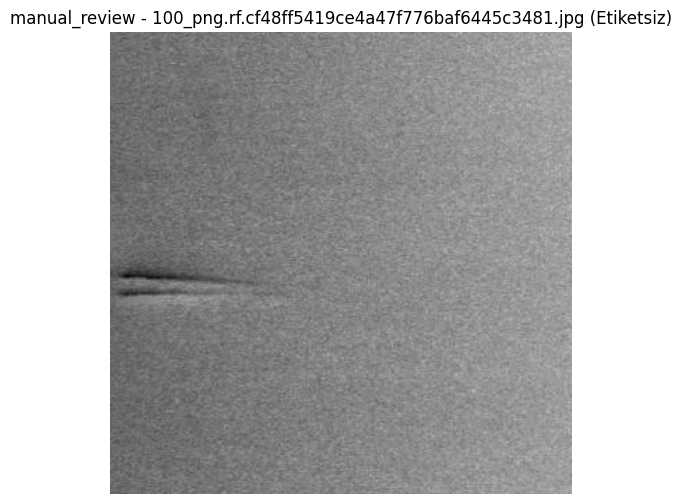

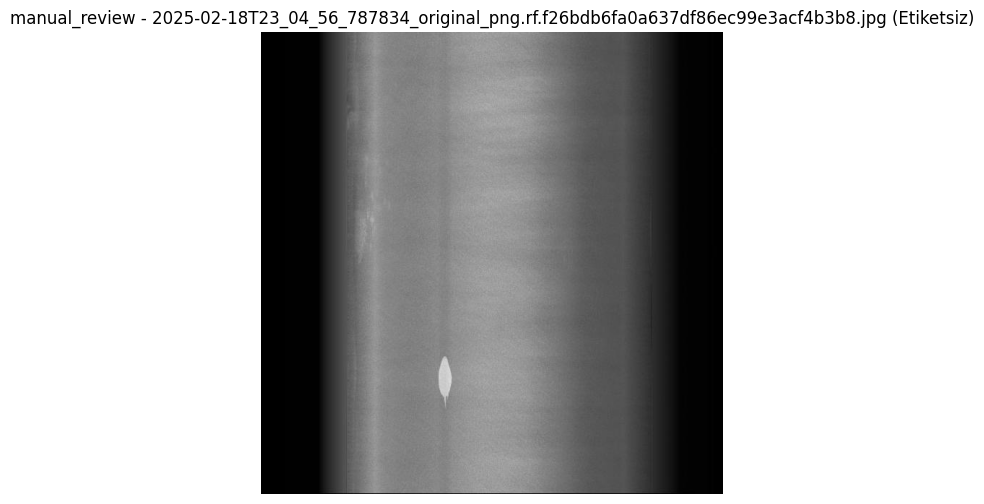

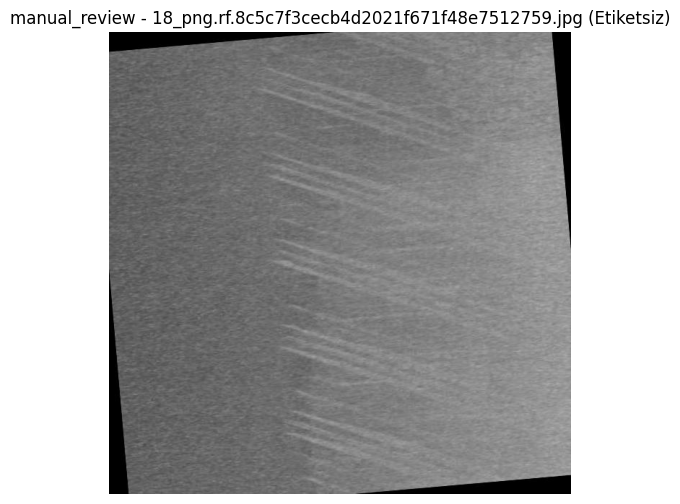


Atlanan Örnekler:


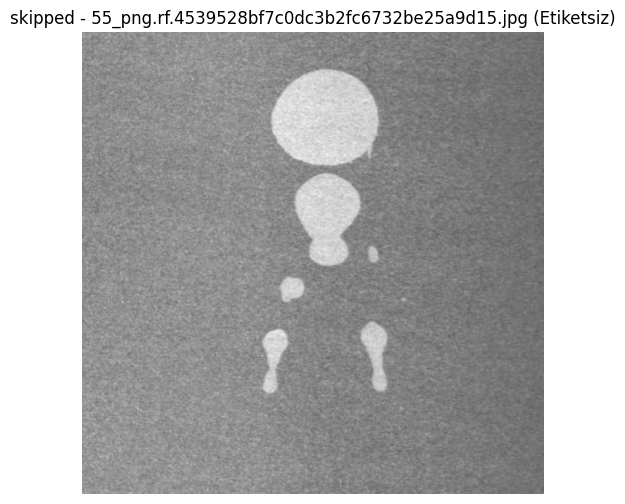

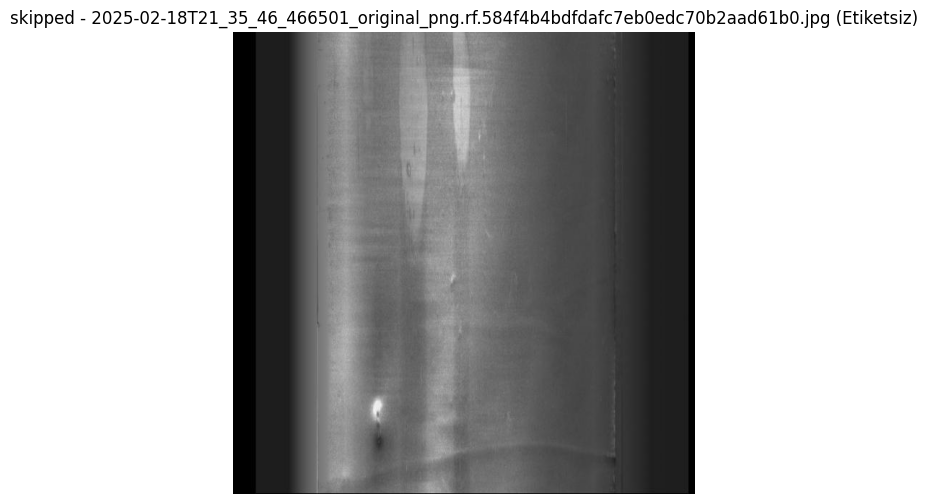

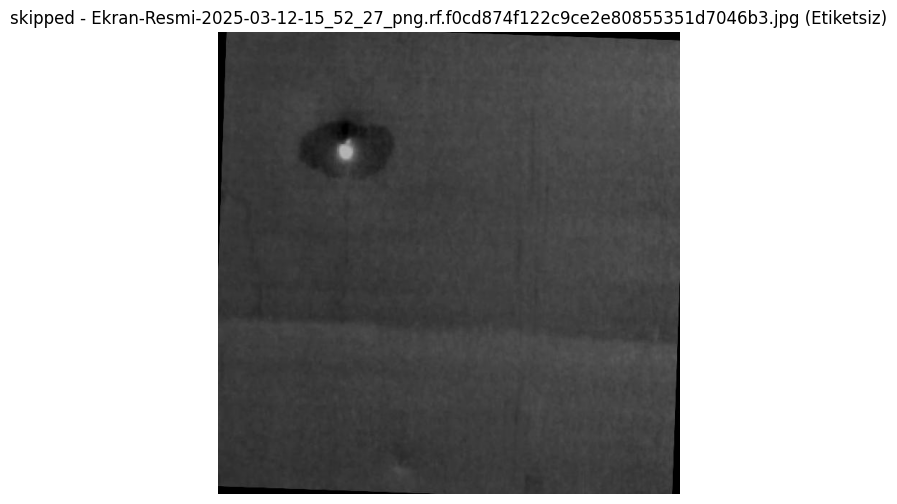

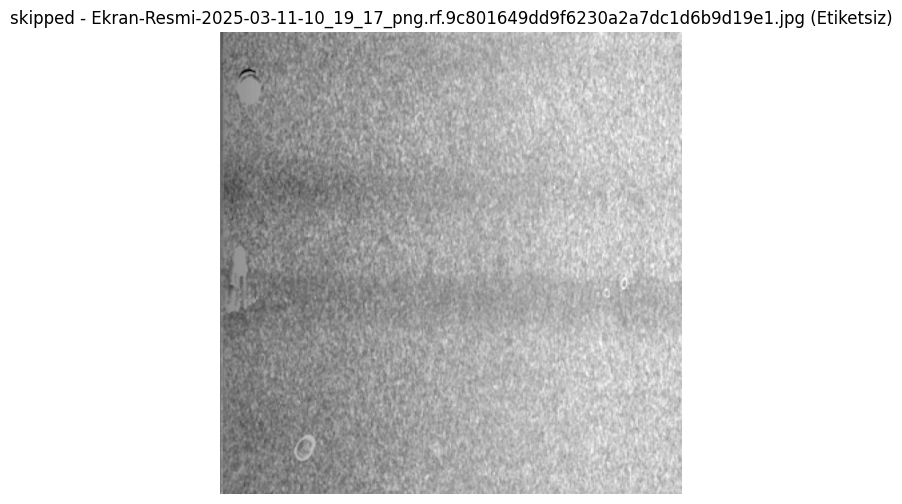

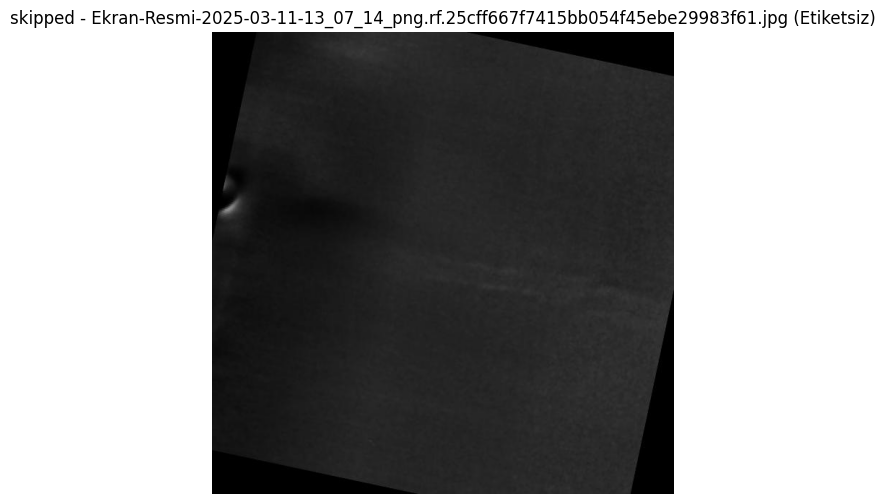

In [ ]:
import matplotlib.pyplot as plt
import random

def analyze_sample(folder, num_samples=5):
    files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not files:
        print(f"{folder} klasöründe görüntü yok.")
        return

    samples = random.sample(files, min(num_samples, len(files)))

    for sample in samples:
        img_path = os.path.join(folder, sample)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Etiket dosyası var mı?
        label_path = os.path.join(folder, os.path.splitext(sample)[0] + '.txt')
        has_label = os.path.exists(label_path)

        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        plt.title(f"{os.path.basename(folder)} - {sample} {'(Etiketli)' if has_label else '(Etiketsiz)'}")
        plt.axis('off')
        plt.show()

        # Etiket içeriğini göster
        if has_label:
            with open(label_path, 'r') as f:
                print(f"Etiket içeriği:\n{f.read()}")

# Her klasörden örnekleri incele
print("Otomatik Kabul Edilen Örnekler:")
analyze_sample("output_labels/auto_accepted")

print("\nManuel İnceleme Gerektiren Örnekler:")
analyze_sample("output_labels/manual_review")

print("\nAtlanan Örnekler:")
analyze_sample("output_labels/skipped")

In [ ]:
def analyze_detections(folder):
    files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not files:
        return [], []

    confidences = []
    object_counts = []

    for img_file in files[:10]:  # İlk 10 görüntüyü analiz et
        img_path = os.path.join(folder, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        results = model(img)[0]
        if len(results.boxes) > 0:
            confidences.extend(results.boxes.conf.cpu().numpy())
            object_counts.append(len(results.boxes))

    return confidences, object_counts

# Her klasördeki tespitleri analiz et
auto_conf, auto_counts = analyze_detections("output_labels/auto_accepted")
manual_conf, manual_counts = analyze_detections("output_labels/manual_review")
skipped_conf, skipped_counts = analyze_detections("output_labels/skipped")

print("Ortalama Güven Skorları:")
print(f"Otomatik Kabul: {sum(auto_conf)/len(auto_conf) if auto_conf else 0}")
print(f"Manuel İnceleme: {sum(manual_conf)/len(manual_conf) if manual_conf else 0}")
print(f"Atlanan: {sum(skipped_conf)/len(skipped_conf) if skipped_conf else 0}")

print("\nOrtalama Nesne Sayıları:")
print(f"Otomatik Kabul: {sum(auto_counts)/len(auto_counts) if auto_counts else 0}")
print(f"Manuel İnceleme: {sum(manual_counts)/len(manual_counts) if manual_counts else 0}")
print(f"Atlanan: {sum(skipped_counts)/len(skipped_counts) if skipped_counts else 0}")


0: 640x640 1 batik, 3 kirisiks, 286.7ms
Speed: 6.1ms preprocess, 286.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leke, 266.7ms
Speed: 8.0ms preprocess, 266.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leke, 262.7ms
Speed: 4.0ms preprocess, 262.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leke, 1 su, 243.4ms
Speed: 6.0ms preprocess, 243.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 batik, 248.7ms
Speed: 6.6ms preprocess, 248.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 238.1ms
Speed: 6.2ms preprocess, 238.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leke, 250.2ms
Speed: 3.6ms preprocess, 250.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leke, 446.1ms
Speed: 6.8ms preprocess, 446.1ms inference, 1.4ms postprocess

In [ ]:
"""
import torch
import torch.nn as nn

# DQN modeli sınıfını tekrar tanımla (ana kodunuzda olduğu gibi)
class DQNModel(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQNModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.network(x)

# Modeli yükle
checkpoint = torch.load("rl_agent.pth")
policy_net = DQNModel(5, 3)  # state_dim=5, action_dim=3
policy_net.load_state_dict(checkpoint['policy_net'])
policy_net.eval()

# Farklı tespit durumları için modelin kararını test et
test_cases = [
    # [sınıf_sayısı, max_güven, ortalama_güven, nesne_sayısı, güven_std]
    [3, 0.95, 0.90, 5, 0.05],  # Yüksek güven, çoklu nesne
    [1, 0.85, 0.85, 1, 0.0],   # Yüksek güven, tek nesne
    [2, 0.55, 0.50, 3, 0.1],   # Orta güven
    [1, 0.35, 0.30, 2, 0.1],   # Düşük güven
    [0, 0.0, 0.0, 0, 0.0]      # Hiç tespit yok
]

print("RL Model Kararları (0=Kabul, 1=Manuel İnceleme, 2=Atla):")
for i, state in enumerate(test_cases):
    with torch.no_grad():
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values = policy_net(state_tensor)
        action = q_values.max(1)[1].item()

        print(f"Durum {i+1}: {state}")
        print(f"Q-değerleri: {q_values.numpy()[0]}")
        print(f"Karar: {action} ({'Kabul' if action==0 else 'Manuel İnceleme' if action==1 else 'Atla'})")
        print("-" * 60)

In [ ]:
#dynamic Reinforcement learning

In [ ]:
import torch
import torch.nn as nn
import json
import os
import numpy as np
from datetime import datetime

# DQN model sınıfı
class DQNModel(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQNModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.network(x)

class OtomatikEtiketleyici:
    def __init__(self, model_yolu, state_dim=5, action_dim=3):
        """
        Eğitilmiş DQN modelini kullanarak otomatik etiketleme yapan sınıf

        Args:
            model_yolu: Eğitilmiş DQN modelinin yükleneceği dosya yolu
            state_dim: Durum vektörünün boyutu
            action_dim: Aksiyon sayısı
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self._model_yukle(model_yolu, state_dim, action_dim)
        self.karar_esikleri = {
            "guven_farki": 0.3,  # Kararlar arasındaki fark bu değerden azsa manuel incelemeye gönder
            "min_kabul_degeri": 0.5  # Kabul için minimum Q değeri
        }
        self.karar_kodlari = {
            0: "Kabul",
            1: "Manuel İnceleme",
            2: "Atla"
        }
        self.log_dosyasi = f"etiketleme_log_{datetime.now().strftime('%Y%m%d')}.json"

    def _model_yukle(self, model_yolu, state_dim, action_dim):
        """Eğitilmiş modeli yükle"""
        try:
            model = DQNModel(state_dim, action_dim).to(self.device)
            checkpoint = torch.load(model_yolu, map_location=self.device)
            model.load_state_dict(checkpoint['policy_net'])
            model.eval()
            print(f"Model başarıyla yüklendi: {model_yolu}")
            return model
        except Exception as e:
            print(f"Model yükleme hatası: {e}")
            raise

    def q_degerleri_hesapla(self, durum):
        """Verilen durum için Q değerlerini hesaplar"""
        with torch.no_grad():
            state_tensor = torch.FloatTensor(durum).unsqueeze(0).to(self.device)
            q_values = self.model(state_tensor)
            return q_values.cpu().numpy()[0]

    def karar_ver(self, durum, guven_esigi=None):
        """
        Verilen durum için karar ver ve güven skorunu hesapla

        Args:
            durum: [sınıf_sayısı, max_güven, ortalama_güven, nesne_sayısı, güven_std] formatında durum vektörü
            guven_esigi: Özel güven eşiği (None ise varsayılan kullanılır)

        Returns:
            (karar_kodu, karar_metni, q_degerleri, guven_skoru) şeklinde tuple
        """
        if guven_esigi is None:
            guven_esigi = self.karar_esikleri["guven_farki"]

        # Q değerlerini hesapla
        q_degerleri = self.q_degerleri_hesapla(durum)

        # En yüksek Q değerine sahip eylemi bul
        en_iyi_eylem = np.argmax(q_degerleri)
        en_iyi_deger = q_degerleri[en_iyi_eylem]

        # İkinci en iyi değeri bul
        q_kopyasi = q_degerleri.copy()
        q_kopyasi[en_iyi_eylem] = float('-inf')
        ikinci_en_iyi = np.max(q_kopyasi)

        # Güven skoru hesapla (en iyi ve ikinci en iyi arasındaki fark)
        guven_skoru = en_iyi_deger - ikinci_en_iyi

        # Karar dinamik olarak belirle
        nihai_karar = en_iyi_eylem

        # Eğer güven skoru düşükse veya en iyi eylem kabul ama değeri düşükse manuel incelemeye gönder
        if guven_skoru < guven_esigi or (en_iyi_eylem == 0 and en_iyi_deger < self.karar_esikleri["min_kabul_degeri"]):
            nihai_karar = 1  # Manuel incelemeye gönder

        return (nihai_karar, self.karar_kodlari[nihai_karar], q_degerleri, guven_skoru)

    def log_kaydet(self, durum, karar, q_degerleri, guven_skoru, etiket_id=None):
        """Karar loglarını kaydet"""
        log_girisi = {
            "tarih": datetime.now().isoformat(),
            "etiket_id": etiket_id,
            "durum": durum,
            "q_degerleri": q_degerleri.tolist(),
            "karar": karar,
            "guven_skoru": float(guven_skoru)
        }

        with open(self.log_dosyasi, 'a') as f:
            f.write(json.dumps(log_girisi) + '\n')

    def toplu_etiketle(self, veri_listesi):
        """
        Bir veri listesini toplu olarak etiketler

        Args:
            veri_listesi: [durum, etiket_id] çiftlerinden oluşan liste

        Returns:
            Etiketlenmiş verilerin listesi
        """
        sonuclar = []

        for veri in veri_listesi:
            if len(veri) == 2:
                durum, etiket_id = veri
            else:
                durum = veri
                etiket_id = None

            karar_kodu, karar_metni, q_degerleri, guven_skoru = self.karar_ver(durum)
            self.log_kaydet(durum, karar_kodu, q_degerleri, guven_skoru, etiket_id)

            sonuclar.append({
                "etiket_id": etiket_id,
                "durum": durum,
                "karar_kodu": karar_kodu,
                "karar": karar_metni,
                "guven_skoru": float(guven_skoru)
            })

        return sonuclar

# Kullanım örneği
def main():
    # Etiketleyiciyi başlat
    etiketleyici = OtomatikEtiketleyici("rl_agent.pth")

    # Test durumları
    test_cases = [
        # [sınıf_sayısı, max_güven, ortalama_güven, nesne_sayısı, güven_std], etiket_id
        [[3, 0.95, 0.90, 5, 0.05], "img_001"],  # Yüksek güven, çoklu nesne
        [[1, 0.85, 0.85, 1, 0.0], "img_002"],   # Yüksek güven, tek nesne
        [[2, 0.55, 0.50, 3, 0.1], "img_003"],   # Orta güven
        [[1, 0.35, 0.30, 2, 0.1], "img_004"],   # Düşük güven
        [[0, 0.0, 0.0, 0, 0.0], "img_005"]      # Hiç tespit yok
    ]

    # Toplu etiketleme
    sonuclar = etiketleyici.toplu_etiketle(test_cases)

    # Sonuçları göster
    print("Etiketleme Sonuçları:")
    print("-" * 60)
    for sonuc in sonuclar:
        print(f"ID: {sonuc['etiket_id']}")
        print(f"Durum: {sonuc['durum']}")
        print(f"Karar: {sonuc['karar_kodu']} ({sonuc['karar']})")
        print(f"Güven Skoru: {sonuc['guven_skoru']:.4f}")
        print("-" * 60)


In [ ]:
import os
import shutil

# Kaynak klasörler
source_folders = ["auto_accepted", "manual_review", "skipped"]

# Hedef klasör
destination_base = "/Users/sumeyye/Desktop/RL_images"

# Hedef klasörü oluştur (eğer yoksa)
if not os.path.exists(destination_base):
    os.makedirs(destination_base)

# Her bir klasörü kopyala
for folder in source_folders:
    source_path = os.path.join(os.getcwd(), folder)  # Mevcut çalışma dizinindeki klasör
    destination_path = os.path.join(destination_base, folder)

    # Eğer klasör zaten varsa, öncekini sil
    if os.path.exists(destination_path):
        shutil.rmtree(destination_path)

    # Klasörü kopyala
    if os.path.exists(source_path):
        print(f"Kopyalanıyor: {source_path} -> {destination_path}")
        shutil.copytree(source_path, destination_path)
    else:
        print(f"Uyarı: {source_path} bulunamadı!")

print("İşlem tamamlandı!")

Uyarı: /content/auto_accepted bulunamadı!
Uyarı: /content/manual_review bulunamadı!
Uyarı: /content/skipped bulunamadı!
İşlem tamamlandı!


In [ ]:
!zip -r my_data.zip /content/output_labels/auto_accepted /content/output_labels/manual_review /content/output_labels/skipped

updating: content/output_labels/auto_accepted/ (stored 0%)
updating: content/output_labels/auto_accepted/9_png.rf.a4245fc813d31952962d77715156ccee.jpg (deflated 5%)
updating: content/output_labels/auto_accepted/Ekran-Resmi-2025-03-10-17_15_27_png.rf.551123615ab6cd6362904e82916e8f91.txt (deflated 41%)
updating: content/output_labels/auto_accepted/Ekran-Resmi-2025-03-11-17_28_33_png.rf.2d929c656a7307b83ddc54d643a4cf88.jpg (deflated 6%)
updating: content/output_labels/auto_accepted/Ekran-Resmi-2025-03-11-17_16_26_png.rf.babecc55af4c08072a58182958b5732b.jpg (deflated 6%)
updating: content/output_labels/auto_accepted/Ekran-Resmi-2025-03-11-17_13_32_png.rf.7b7c8386e254cd140f08575c3822e0b3.jpg (deflated 6%)
updating: content/output_labels/auto_accepted/Ekran-Resmi-2025-03-12-15_49_45_png.rf.32aff928d6a96c3cef6e99fe87ea77fd.jpg (deflated 7%)
updating: content/output_labels/auto_accepted/Ekran-Resmi-2025-03-11-13_03_26_png.rf.9bac6cd805d8ddd85a4f3e11f504ce37.jpg (deflated 6%)
updating: content/

In [ ]:
from google.colab import files
files.download("my_data.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pip install ultralytics #stable-baselines3 gymnasium torch torchvision

from ultralytics import YOLO
import numpy as np

# YOLOv8 modelini yükle
model = YOLO("yolov8n.pt")

# Görseldeki kusurları tespit eden fonksiyon
def detect_defects(image_path):
    results = model(image_path)
    detections = []

    # Modelin tespit ettiği nesnelerden bounding box bilgilerini al
    for r in results:
        for box in r.boxes.data.tolist():
            x1, y1, x2, y2, conf = box[:5]  # (x1, y1, x2, y2, confidence)
            detections.append((x1, y1, x2, y2, conf))

    return detections

import gym
import random

class DefectLabelingEnv(gym.Env):
    def __init__(self, image_path):
        super(DefectLabelingEnv, self).__init__()
        self.image_path = image_path
        self.detections = detect_defects(image_path)  # YOLOv8 ile tespit edilen bölgeler
        self.action_space = gym.spaces.Discrete(3)  # 0: Kusurlu, 1: Kusursuz, 2: Belirsiz

        # Gözlem alanı sadece 5 boyutlu: (x1, y1, x2, y2, conf)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)
        self.index = 0  # İşlenecek nesnenin sırası

    def step(self, action):
        x1, y1, x2, y2, conf = self.detections[self.index]

        # Simüle edilmiş gerçek etiket (Bunu datasetinize göre değiştirebilirsiniz)
        true_label = random.choice([0, 1])

        # Ödül fonksiyonu
        reward = 1 if action == true_label else -1

        self.index += 1
        done = self.index >= len(self.detections)

        # Yeni `state` artık sadece (5,) boyutunda
        next_state = np.array([x1, y1, x2, y2, conf], dtype=np.float32)

        return next_state, reward, done, {}

    def reset(self):
        self.index = 0
        x1, y1, x2, y2, conf = self.detections[self.index]
        return np.array([x1, y1, x2, y2, conf], dtype=np.float32)
import torch
import torch.nn as nn
import torch.optim as optim

class DRLModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(DRLModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),  # Artık input_size = 5
            nn.ReLU(),
            nn.Linear(128, output_size)
        )

    def forward(self, x):
        return self.fc(x)

# Modeli oluştur
model = DRLModel(5, 3)  # 5 giriş (bounding box bilgileri), 3 çıkış (kusurlu, kusursuz, belirsiz)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

import cv2
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np

class DefectLabelingEnv:
    def __init__(self, image_folder_path):
        self.image_paths = [os.path.join(image_folder_path, f) for f in os.listdir(image_folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
        # Transform operations
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize to a more standard size
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def reset(self):
        self.current_image_idx = 0
        return self._get_state()

    def _get_state(self):
        self.current_image_path = self.image_paths[self.current_image_idx]
        img = Image.open(self.current_image_path).convert("RGB")
        img_tensor = self.transform(img)

        # Extract 5 features from the image for the state
        # This is a simple example - you might want to use a feature extractor in practice
        # For now, we'll just use basic statistics of the image as features
        features = [
            img_tensor.mean().item(),  # Mean pixel value
            img_tensor.std().item(),   # Standard deviation
            img_tensor[0].mean().item(),  # Red channel mean
            img_tensor[1].mean().item(),  # Green channel mean
            img_tensor[2].mean().item()   # Blue channel mean
        ]

        return np.array(features, dtype=np.float32)

    def step(self, action):
        # Process the action (not implemented in this example)

        # Move to the next image
        self.current_image_idx += 1
        if self.current_image_idx >= len(self.image_paths):
            self.current_image_idx = 0
            done = True
        else:
            done = False

        # Get the new state
        new_state = self._get_state()

        # Simple reward function
        reward = 1.0

        return new_state, reward, done

# Define your DQN model
class DQN(torch.nn.Module):
    def __init__(self, state_size=5, action_size=2):
        super(DQN, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(state_size, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, action_size)
        )

    def forward(self, x):
        return self.fc(x)

# Training function
def train_drl(env, model, episodes=1000):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Convert state to tensor
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # [1, 5]

            # Get action from model
            q_values = model(state_tensor)
            action = torch.argmax(q_values).item()

            # Take action in environment
            next_state, reward, done = env.step(action)
            total_reward += reward

            # Convert next_state to tensor
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

            # Calculate target Q-value
            target_q = reward + 0.99 * torch.max(model(next_state_tensor)).item() * (1 - done)

            # Update model
            target = q_values.clone()
            target[0, action] = target_q

            loss = criterion(q_values, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state

        if episode % 10 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}")

# Create environment and model
env = DefectLabelingEnv("/content/drive/MyDrive/My Project-2/train/images")
model = DQN(state_size=5, action_size=2)  # Assuming 2 possible actions

# Train the model
#train_drl(env, model)

import os
import cv2
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from ultralytics import YOLO
from collections import deque
from PIL import Image

# Sabitler
MEMORY_SIZE = 5000
BATCH_SIZE = 32
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995
LEARNING_RATE = 0.001

class DQNModel(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQNModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.network(x)

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        if len(self.memory) < batch_size:
            return None
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

class RLAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.policy_net = DQNModel(state_dim, action_dim)
        self.target_net = DQNModel(state_dim, action_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)
        self.memory = ReplayMemory(MEMORY_SIZE)
        self.epsilon = EPSILON_START

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = self.policy_net(state_tensor)
                return q_values.max(1)[1].item()

    def update_epsilon(self):
        self.epsilon = max(EPSILON_END, self.epsilon * EPSILON_DECAY)

    def optimize(self):
        batch = self.memory.sample(BATCH_SIZE)
        if batch is None:
            return

        states, actions, rewards, next_states, dones = batch

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        current_q = self.policy_net(states).gather(1, actions)
        next_q = self.target_net(next_states).max(1)[0].detach()
        target_q = rewards + (1 - dones) * GAMMA * next_q

        loss = nn.MSELoss()(current_q.squeeze(), target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Hedef ağı güncelle
        self.target_net.load_state_dict(self.policy_net.state_dict())

def extract_features(results):
    # YOLO sonuçlarından özellik çıkarma
    boxes = results.boxes
    if len(boxes) == 0:
        return np.zeros(5)  # Boş özellik vektörü

    confidences = boxes.conf.cpu().numpy()
    classes = boxes.cls.cpu().numpy() if len(boxes.cls) > 0 else np.array([])

    features = [
        len(np.unique(classes)) if len(classes) > 0 else 0,  # Benzersiz sınıf sayısı
        np.max(confidences) if len(confidences) > 0 else 0,  # En yüksek güven skoru
        np.mean(confidences) if len(confidences) > 0 else 0,  # Ortalama güven skoru
        len(confidences),  # Toplam kutu sayısı
        np.std(confidences) if len(confidences) > 1 else 0  # Güven skorlarının standart sapması
    ]

    return np.array(features)

def save_yolo_labels(results, output_path, img_shape):
    # YOLO tespit sonuçlarını standart YOLO etiket formatında kaydet
    height, width = img_shape[:2]
    with open(output_path, 'w') as f:
        if hasattr(results.boxes, 'cls') and len(results.boxes.cls) > 0:
            for i, box in enumerate(results.boxes.xyxyn):
                cls = int(results.boxes.cls[i].item())
                x1, y1, x2, y2 = box[0].item(), box[1].item(), box[2].item(), box[3].item()

                # YOLO formatına dönüştür (orta nokta + genişlik-yükseklik)
                x_center = (x1 + x2) / 2
                y_center = (y1 + y2) / 2
                w = x2 - x1
                h = y2 - y1

                f.write(f"{cls} {x_center} {y_center} {w} {h}\n")

def main():
    # YOLOv8 modelini yükle
    model_path = "/content/drive/MyDrive/yolov8_model.pt"  # Sizin modelinizin yolu
    print(f"YOLOv8 modeli yükleniyor: {model_path}")
    model = YOLO(model_path)

    # Klasörleri oluştur
    image_folder = "/content/drive/MyDrive/RL deep/train/images"  # Etiketlenmemiş görüntülerin bulunduğu klasör
    if not os.path.exists(image_folder):
        print(f"'{image_folder}' klasörü bulunamadı. Lütfen görüntüleriniz için bu klasörü oluşturun.")
        return

    output_dir = "output_labels"
    os.makedirs(os.path.join(output_dir, "auto_accepted"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "manual_review"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "skipped"), exist_ok=True)

    # RL ajanını başlat
    state_dim = 5  # Özellik vektörünün boyutu
    action_dim = 3  # Eylem sayısı (kabul et, manuel inceleme, atla)
    agent = RLAgent(state_dim, action_dim)

    # Görüntü dosyalarını listele
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        print(f"'{image_folder}' klasöründe görüntü dosyası bulunamadı.")
        return

    print(f"Toplam {len(image_files)} görüntü işlenecek.")

    # Eğitim döngüsü
    epochs = 3
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        random.shuffle(image_files)

        for idx, filename in enumerate(image_files):
            img_path = os.path.join(image_folder, filename)
            image = cv2.imread(img_path)
            if image is None:
                print(f"Görüntü yüklenemedi: {img_path}")
                continue

            # YOLOv8 tespiti yap
            results = model(image)[0]

            # Özellik çıkar
            state = extract_features(results)

            # Eylemi seç
            action = agent.select_action(state)

            # Geri bildirimi simüle et (gerçek kullanımda kullanıcı tarafından sağlanmalı)
            confidences = results.boxes.conf.cpu().numpy() if hasattr(results.boxes, 'conf') else np.array([])
            if len(confidences) > 0:
                avg_conf = np.mean(confidences)
                if avg_conf > 0.7:
                    ideal_action = 0  # Kabul et
                elif avg_conf > 0.4:
                    ideal_action = 1  # Manuel inceleme
                else:
                    ideal_action = 2  # Atla
            else:
                ideal_action = 2  # Tespit yoksa atla

            # Ödül belirle
            reward = 1.0 if action == ideal_action else -0.5

            # Hafızaya ekle
            agent.memory.add(state, action, reward, state, True)

            # Optimize et
            if len(agent.memory) >= BATCH_SIZE:
                agent.optimize()

            # Epsilon'u güncelle
            agent.update_epsilon()

            # Eylemi uygula ve sonucu kaydet
            base_name = os.path.splitext(filename)[0]

            if action == 0:  # Otomatik kabul
                output_img_path = os.path.join(output_dir, "auto_accepted", filename)
                label_path = os.path.join(output_dir, "auto_accepted", f"{base_name}.txt")
                cv2.imwrite(output_img_path, image)
                save_yolo_labels(results, label_path, image.shape)
                action_text = "kabul edildi"

            elif action == 1:  # Manuel inceleme
                output_img_path = os.path.join(output_dir, "manual_review", filename)
                cv2.imwrite(output_img_path, image)
                action_text = "manuel inceleme gerekiyor"

            else:  # Atla
                output_img_path = os.path.join(output_dir, "skipped", filename)
                cv2.imwrite(output_img_path, image)
                action_text = "atlandı"

            if (idx + 1) % 10 == 0:
                print(f"İşlenen görüntü: {idx+1}/{len(image_files)} - Epsilon: {agent.epsilon:.3f}")

    print("Eğitim tamamlandı.")

    # Modeli kaydet
    torch.save({
        'policy_net': agent.policy_net.state_dict(),
        'epsilon': agent.epsilon,
    }, "rl_agent.pth")
    print("RL ajanı kaydedildi: rl_agent.pth")

    print("\nİşlem Özeti:")
    print(f"Toplam İşlenen Görüntü: {len(image_files)}")
    auto_accepted = len(os.listdir(os.path.join(output_dir, "auto_accepted")))
    manual_review = len(os.listdir(os.path.join(output_dir, "manual_review")))
    skipped = len(os.listdir(os.path.join(output_dir, "skipped")))

    print(f"Otomatik Kabul Edilen: {auto_accepted}")
    print(f"Manuel İnceleme Gerektiren: {manual_review}")
    print(f"Atlanan: {skipped}")
import os
import shutil
from collections import Counter

# Klasörlerdeki dosya sayıları
auto_accepted = os.listdir("output_labels/auto_accepted")
manual_review = os.listdir("output_labels/manual_review")
skipped = os.listdir("output_labels/skipped")

print(f"Auto Accepted: {len(auto_accepted)} dosya")
print(f"Manuel İnceleme: {len(manual_review)} dosya")
print(f"Atlanan: {len(skipped)} dosya")

# Orijinal görüntü adlarını analiz et
auto_names = [os.path.splitext(f)[0] for f in auto_accepted if not f.endswith('.txt')]
manual_names = [os.path.splitext(f)[0] for f in manual_review]
skipped_names = [os.path.splitext(f)[0] for f in skipped]

# Tüm görüntü adlarını bir araya getir
all_names = auto_names + manual_names + skipped_names
duplicates = [item for item, count in Counter(all_names).items() if count > 1]

print(f"Tekrarlanan görüntü adları: {len(duplicates)}")

from ultralytics import YOLO
import cv2

model = YOLO("/content/drive/MyDrive/yolov8_model.pt")

# Örnek bir görüntüyü incele
sample_auto = os.path.join("output_labels/auto_accepted", auto_accepted[0])
if os.path.isfile(sample_auto) and not sample_auto.endswith('.txt'):
    img = cv2.imread(sample_auto)
    results = model(img)[0]

    print(f"Örnek otomatik kabul edilen görüntü: {sample_auto}")
    print(f"Tespit edilen nesne sayısı: {len(results.boxes)}")
    print(f"Ortalama güven skoru: {results.boxes.conf.mean().item() if len(results.boxes) > 0 else 0}")

import torch

# RL modelini yükle
rl_model = torch.load("rl_agent.pth")
print("RL model bilgileri:")
print(f"Epsilon değeri: {rl_model['epsilon']}")

# Otomatik kabul edilen etiketleri kontrol et
txt_files = [f for f in auto_accepted if f.endswith('.txt')]
if txt_files:
    sample_label = os.path.join("output_labels/auto_accepted", txt_files[0])
    print(f"Örnek etiket içeriği: {sample_label}")
    with open(sample_label, 'r') as f:
        content = f.read()
        print(content)

import matplotlib.pyplot as plt
import random

def analyze_sample(folder, num_samples=5):
    files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not files:
        print(f"{folder} klasöründe görüntü yok.")
        return

    samples = random.sample(files, min(num_samples, len(files)))

    for sample in samples:
        img_path = os.path.join(folder, sample)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Etiket dosyası var mı?
        label_path = os.path.join(folder, os.path.splitext(sample)[0] + '.txt')
        has_label = os.path.exists(label_path)

        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        plt.title(f"{os.path.basename(folder)} - {sample} {'(Etiketli)' if has_label else '(Etiketsiz)'}")
        plt.axis('off')
        plt.show()

        # Etiket içeriğini göster
        if has_label:
            with open(label_path, 'r') as f:
                print(f"Etiket içeriği:\n{f.read()}")

# Her klasörden örnekleri incele
print("Otomatik Kabul Edilen Örnekler:")
analyze_sample("output_labels/auto_accepted")

print("\nManuel İnceleme Gerektiren Örnekler:")
analyze_sample("output_labels/manual_review")

print("\nAtlanan Örnekler:")
analyze_sample("output_labels/skipped")

def analyze_detections(folder):
    files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not files:
        return [], []

    confidences = []
    object_counts = []

    for img_file in files[:10]:  # İlk 10 görüntüyü analiz et
        img_path = os.path.join(folder, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        results = model(img)[0]
        if len(results.boxes) > 0:
            confidences.extend(results.boxes.conf.cpu().numpy())
            object_counts.append(len(results.boxes))

    return confidences, object_counts

# Her klasördeki tespitleri analiz et
auto_conf, auto_counts = analyze_detections("output_labels/auto_accepted")
manual_conf, manual_counts = analyze_detections("output_labels/manual_review")
skipped_conf, skipped_counts = analyze_detections("output_labels/skipped")

print("Ortalama Güven Skorları:")
print(f"Otomatik Kabul: {sum(auto_conf)/len(auto_conf) if auto_conf else 0}")
print(f"Manuel İnceleme: {sum(manual_conf)/len(manual_conf) if manual_conf else 0}")
print(f"Atlanan: {sum(skipped_conf)/len(skipped_conf) if skipped_conf else 0}")

print("\nOrtalama Nesne Sayıları:")
print(f"Otomatik Kabul: {sum(auto_counts)/len(auto_counts) if auto_counts else 0}")
print(f"Manuel İnceleme: {sum(manual_counts)/len(manual_counts) if manual_counts else 0}")
print(f"Atlanan: {sum(skipped_counts)/len(skipped_counts) if skipped_counts else 0}")



import torch
import torch.nn as nn
import json
import os
import numpy as np
from datetime import datetime

# DQN model sınıfı
class DQNModel(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQNModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.network(x)

class OtomatikEtiketleyici:
    def __init__(self, model_yolu, state_dim=5, action_dim=3):
        """
        Eğitilmiş DQN modelini kullanarak otomatik etiketleme yapan sınıf

        Args:
            model_yolu: Eğitilmiş DQN modelinin yükleneceği dosya yolu
            state_dim: Durum vektörünün boyutu
            action_dim: Aksiyon sayısı
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self._model_yukle(model_yolu, state_dim, action_dim)
        self.karar_esikleri = {
            "guven_farki": 0.3,  # Kararlar arasındaki fark bu değerden azsa manuel incelemeye gönder
            "min_kabul_degeri": 0.5  # Kabul için minimum Q değeri
        }
        self.karar_kodlari = {
            0: "Kabul",
            1: "Manuel İnceleme",
            2: "Atla"
        }
        self.log_dosyasi = f"etiketleme_log_{datetime.now().strftime('%Y%m%d')}.json"

    def _model_yukle(self, model_yolu, state_dim, action_dim):
        """Eğitilmiş modeli yükle"""
        try:
            model = DQNModel(state_dim, action_dim).to(self.device)
            checkpoint = torch.load(model_yolu, map_location=self.device)
            model.load_state_dict(checkpoint['policy_net'])
            model.eval()
            print(f"Model başarıyla yüklendi: {model_yolu}")
            return model
        except Exception as e:
            print(f"Model yükleme hatası: {e}")
            raise

    def q_degerleri_hesapla(self, durum):
        """Verilen durum için Q değerlerini hesaplar"""
        with torch.no_grad():
            state_tensor = torch.FloatTensor(durum).unsqueeze(0).to(self.device)
            q_values = self.model(state_tensor)
            return q_values.cpu().numpy()[0]

    def karar_ver(self, durum, guven_esigi=None):
        """
        Verilen durum için karar ver ve güven skorunu hesapla

        Args:
            durum: [sınıf_sayısı, max_güven, ortalama_güven, nesne_sayısı, güven_std] formatında durum vektörü
            guven_esigi: Özel güven eşiği (None ise varsayılan kullanılır)

        Returns:
            (karar_kodu, karar_metni, q_degerleri, guven_skoru) şeklinde tuple
        """
        if guven_esigi is None:
            guven_esigi = self.karar_esikleri["guven_farki"]

        # Q değerlerini hesapla
        q_degerleri = self.q_degerleri_hesapla(durum)

        # En yüksek Q değerine sahip eylemi bul
        en_iyi_eylem = np.argmax(q_degerleri)
        en_iyi_deger = q_degerleri[en_iyi_eylem]

        # İkinci en iyi değeri bul
        q_kopyasi = q_degerleri.copy()
        q_kopyasi[en_iyi_eylem] = float('-inf')
        ikinci_en_iyi = np.max(q_kopyasi)

        # Güven skoru hesapla (en iyi ve ikinci en iyi arasındaki fark)
        guven_skoru = en_iyi_deger - ikinci_en_iyi

        # Karar dinamik olarak belirle
        nihai_karar = en_iyi_eylem

        # Eğer güven skoru düşükse veya en iyi eylem kabul ama değeri düşükse manuel incelemeye gönder
        if guven_skoru < guven_esigi or (en_iyi_eylem == 0 and en_iyi_deger < self.karar_esikleri["min_kabul_degeri"]):
            nihai_karar = 1  # Manuel incelemeye gönder

        return (nihai_karar, self.karar_kodlari[nihai_karar], q_degerleri, guven_skoru)

    def log_kaydet(self, durum, karar, q_degerleri, guven_skoru, etiket_id=None):
        """Karar loglarını kaydet"""
        log_girisi = {
            "tarih": datetime.now().isoformat(),
            "etiket_id": etiket_id,
            "durum": durum,
            "q_degerleri": q_degerleri.tolist(),
            "karar": karar,
            "guven_skoru": float(guven_skoru)
        }

        with open(self.log_dosyasi, 'a') as f:
            f.write(json.dumps(log_girisi) + '\n')

    def toplu_etiketle(self, veri_listesi):
        """
        Bir veri listesini toplu olarak etiketler

        Args:
            veri_listesi: [durum, etiket_id] çiftlerinden oluşan liste

        Returns:
            Etiketlenmiş verilerin listesi
        """
        sonuclar = []

        for veri in veri_listesi:
            if len(veri) == 2:
                durum, etiket_id = veri
            else:
                durum = veri
                etiket_id = None

            karar_kodu, karar_metni, q_degerleri, guven_skoru = self.karar_ver(durum)
            self.log_kaydet(durum, karar_kodu, q_degerleri, guven_skoru, etiket_id)

            sonuclar.append({
                "etiket_id": etiket_id,
                "durum": durum,
                "karar_kodu": karar_kodu,
                "karar": karar_metni,
                "guven_skoru": float(guven_skoru)
            })

        return sonuclar

# Kullanım örneği
def main():
    # Etiketleyiciyi başlat
    etiketleyici = OtomatikEtiketleyici("rl_agent.pth")

    # Test durumları
    test_cases = [
        # [sınıf_sayısı, max_güven, ortalama_güven, nesne_sayısı, güven_std], etiket_id
        [[3, 0.95, 0.90, 5, 0.05], "img_001"],  # Yüksek güven, çoklu nesne
        [[1, 0.85, 0.85, 1, 0.0], "img_002"],   # Yüksek güven, tek nesne
        [[2, 0.55, 0.50, 3, 0.1], "img_003"],   # Orta güven
        [[1, 0.35, 0.30, 2, 0.1], "img_004"],   # Düşük güven
        [[0, 0.0, 0.0, 0, 0.0], "img_005"]      # Hiç tespit yok
    ]

    # Toplu etiketleme
    sonuclar = etiketleyici.toplu_etiketle(test_cases)

    # Sonuçları göster
    print("Etiketleme Sonuçları:")
    print("-" * 60)
    for sonuc in sonuclar:
        print(f"ID: {sonuc['etiket_id']}")
        print(f"Durum: {sonuc['durum']}")
        print(f"Karar: {sonuc['karar_kodu']} ({sonuc['karar']})")
        print(f"Güven Skoru: {sonuc['guven_skoru']:.4f}")
        print("-" * 60)

import os
import shutil

# Kaynak klasörler
source_folders = ["auto_accepted", "manual_review", "skipped"]

# Hedef klasör
destination_base = "/Users/sumeyye/Desktop/RL_images"

# Hedef klasörü oluştur (eğer yoksa)
if not os.path.exists(destination_base):
    os.makedirs(destination_base)

# Her bir klasörü kopyala
for folder in source_folders:
    source_path = os.path.join(os.getcwd(), folder)  # Mevcut çalışma dizinindeki klasör
    destination_path = os.path.join(destination_base, folder)

    # Eğer klasör zaten varsa, öncekini sil
    if os.path.exists(destination_path):
        shutil.rmtree(destination_path)

    # Klasörü kopyala
    if os.path.exists(source_path):
        print(f"Kopyalanıyor: {source_path} -> {destination_path}")
        shutil.copytree(source_path, destination_path)
    else:
        print(f"Uyarı: {source_path} bulunamadı!")

print("İşlem tamamlandı!")